# import Library

In [45]:
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
from enum import Enum
import pandas as pd
import time
from collections import defaultdict
from collections import namedtuple
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import io
import re
from collections import namedtuple
from collections import deque
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image
import matplotlib.pyplot as plt
import random
from mylibrary.fnframework import FNAgent,Trainer,Experience
from mylibrary.plottrade import PlotTrade
from mylibrary.maketraindata import MakeTrainData
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

# Load DF

In [2]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

# class Environment

In [3]:
class Environment():
    
    
    def __init__(self, x_train, price_chart):
        self.x_train = x_train # state list
        self.time = 0 # x_trainのindex
        self.price_chart = price_chart
        
        
    def reset(self):
        self.time=0
        return self.x_train.iloc[self.time].tolist()
        
    
    def actions(self):
        return [Action.BUY, Action.STAY]
    
    
    
    def state(self):
        return self.x_train.iloc[self.time].tolist()
  
            
    def reward_func(self, action):
        reward=0
        done = False

        if self.time >= len(self.price_chart)-2: 
            done = True
   
        if action==Action.BUY:
            reward=self.price_chart['close'].iloc[self.time+1]-self.price_chart['open'].iloc[self.time+1]

        elif action==Action.STAY:
            reward=0

            
        return reward, done
            
    
    
    def step(self, action):
        reward, done = self.reward_func(action)
        self.time += 1
        next_state = self.state()
        
    
        return next_state, reward, done
        
        
        
    
    

# class Actioin

In [4]:
class Action(Enum):
    BUY  = 0
    STAY = 1


# Value function Agent class

In [51]:
class ValueFunctionAgent(FNAgent):

    
    def save(self, model_path):
        joblib.dump(self.model, model_path)

    
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        actions = list(range(len(Action)))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    
    def initialize(self, experiences):
        scaler = StandardScaler() # 特徴料(列)ごとに標準化してる
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1)
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        states = np.vstack([e.s for e in experiences])
        self.model.named_steps["scaler"].fit(states)

        # Avoid the predict before fit.
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    
    def estimate(self, s):
        s = np.array(s).reshape(1,-1)
        estimated = self.model.predict(s)[0]
        return estimated

    
    def _predict(self, states):
        if self.initialized:
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        return predicteds

    
    def update(self, experiences, gamma):
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])

        estimateds = self._predict(states)
        future = self._predict(n_states)


        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        estimateds = np.array(estimateds)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)
        
    
    def play(self, env, episode_count=10,is_validate=False): 
        actions = env.actions()
        
        for e in range(episode_count):
            s = env.reset()
            done = False
            total_reward = 0
            reward_log = []
#             pl = PlotTrade(env.price_chart)
            trade_count = 0
            is_bought = False
           
            
            while not done:
                a = self.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                total_reward += reward
                s = n_state
                reward_log.append(total_reward)
                #============ render ============


                if action == Action.BUY:
                    trade_count+=1
                
            else:
                if not is_validate:
                    print("==================")
                    print("episode :",e)   
                    print("Get reward {}.".format(total_reward))
                    print("Trade count {}.".format(trade_count))
#                 pl.show()
        return  total_reward, trade_count



# Value function Trainer

In [50]:
class ValueFunctionTrainer(Trainer):

    
    def train(self, env, episode_count=250, epsilon=0.01, initial_count=-1, env_sample=None):
        actions = list(range(len(Action)))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count, env_sample)
        return agent

   
    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    
    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)
      
    
    def episode_end(self, episode, step_count, agent):
#         rewards = [e.r for e in self.get_recent(step_count)]
        pass
        
    
    def train_loop(self, env,agent, episode=200, initial_count=-1,env_sample=None):
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        actions = env.actions()
        reward_log = []
        validate_reward_log = []
        
        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            total_rewards = 0
            
            if i%10==0:
                print("----------------------")
                print("episode :",i)
            
            while not done:
                

                a = agent.policy(s)
                action = actions[a]
                n_state, reward, done = env.step(action)
                e = Experience(s, a, reward, n_state, done)
                total_rewards += reward
                self.experiences.append(e)
                
                
                if not self.training and len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
#                 self.episode_end(i, step_count, agent)
                
                reward_log.append(total_rewards)
#         検証用のlog
                if env_sample!=None:
                    validate_reward, dummy = agent.play(env_sample,is_validate=True)
                    validate_reward_log.append(validate_reward)
                if not self.training and initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True


                if self.training:
                    self.training_count += 1
                    

        print("train reward")         
        plt.clf() 
        plt.plot(reward_log)
        plt.xlabel('episode')
        plt.ylabel('reward')
        plt.show()
        
        
        if env_sample!=None:
            print("validate data reward")
            plt.clf() 
            plt.plot(validate_reward_log)
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.show()

# class PlotCandle

In [41]:
class PlotCandle(PlotTrade):
    
    def __init__(self, df_chart):
        self.df_chart = df_chart
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 1, 1)

        self.mpf = mpf.plot(self.df_chart, type='candle',)
              
   
    
    def add_plot(self, df_plot):
        self.ax.plot(df_plot)
        
        
    def show(self):
        self.ax.grid()
        labels = self.ax.get_xticklabels()
        plt.setp(labels, rotation=15, fontsize=12)
        plt.show()    
    

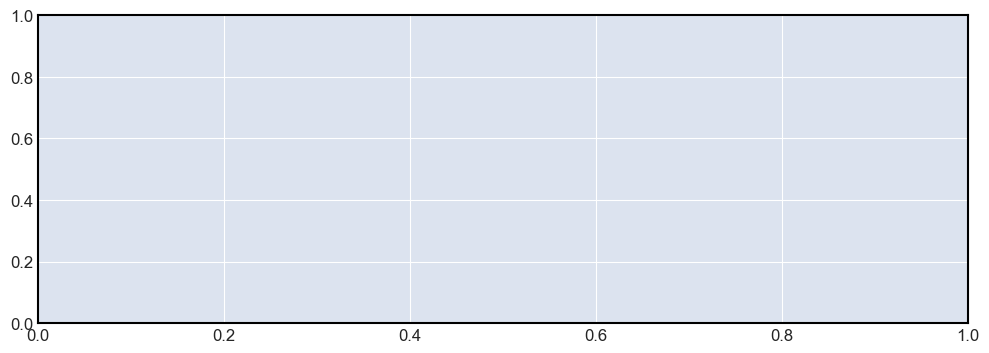

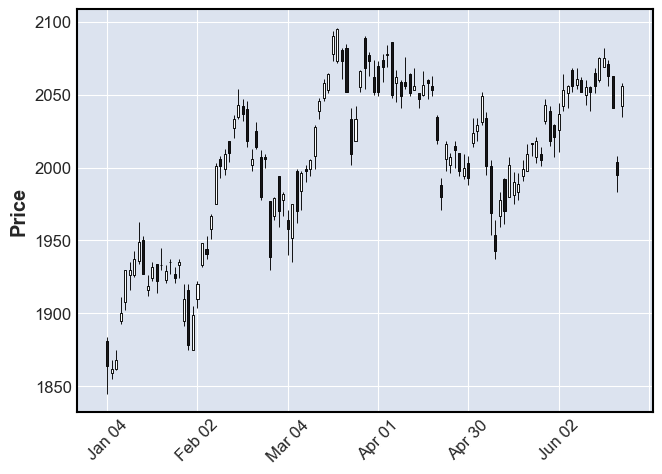

In [42]:
env = Environment(s_test,price_test)
df_chart= env.price_chart
pc = PlotCandle(df_chart)
# fig = plt.figure(figsize=(12, 4))
# ax = fig.add_subplot(1, 1, 1)

# candlestick_ohlc(ax, df_chart, width=2, alpha=0.5, colorup='r', colordown='b')

# func make_train_data

In [19]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'

def make_x_train(path_):
    path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
    df_tpx  = DataFramePreProcessing(path_).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw['dclose'].pct_change()
    tpx_p = df_tpx['close'].pct_change()

    df_con = pd.concat([daw_p,tpx_p],axis = 1,join='inner').astype(float)
    df_tmp = df_con.rename(columns={'close': 'pclose'})
    df_tmp = pd.concat([df_tmp,df_tpx.loc[:,['open','high','low','close']]],axis = 1,join='inner').astype(float)
    x_train = df_tmp.loc[:,['dclose','pclose']].iloc[1:]
    price_chart = df_tmp.loc[:,['open','high','low','close']].iloc[1:]
    return x_train, price_chart

# main

----------------------
episode : 0
Done initialization. From now, begin training!
----------------------
episode : 10
----------------------
episode : 20
----------------------
episode : 30
----------------------
episode : 40
----------------------
episode : 50
----------------------
episode : 60
----------------------
episode : 70
----------------------
episode : 80
----------------------
episode : 90
----------------------
episode : 100
----------------------
episode : 110
----------------------
episode : 120
----------------------
episode : 130
----------------------
episode : 140
----------------------
episode : 150
----------------------
episode : 160
----------------------
episode : 170
----------------------
episode : 180
----------------------
episode : 190
----------------------
episode : 200
----------------------
episode : 210
----------------------
episode : 220
----------------------
episode : 230
----------------------
episode : 240
----------------------
episode : 250
--

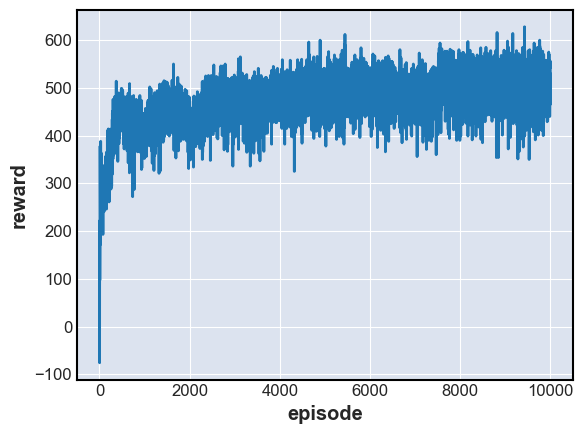

validate data reward


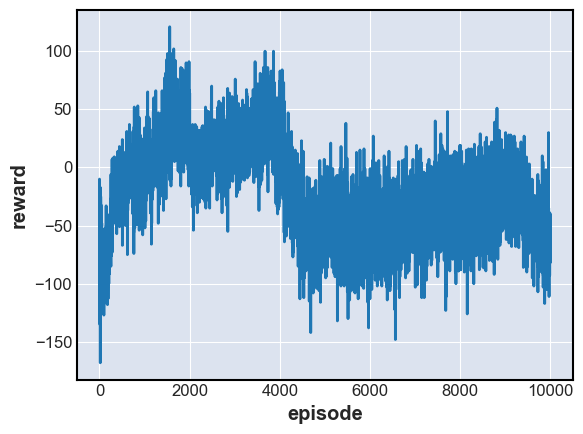

episode : 0
Get reward -67.0.
Trade count 32.


(-67.0, 32)

In [60]:
x_train, price_chart = make_x_train(path_tpx)


train_year = 2020
test_year = 2021


s_train = x_train[x_train.index.year==train_year]
s_test = x_train[x_train.index.year==test_year]

price_train = price_chart[price_chart.index.year==train_year]
price_test  = price_chart[price_chart.index.year==test_year]


env_train = Environment(s_train,price_train)
env_test = Environment(s_test,price_test)
trainer = ValueFunctionTrainer()
trained = trainer.train(env_train,episode_count=10000,env_sample=env_test)   
trained.play(env_test,episode_count=1)